In [9]:
%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)
import matplotlib.pyplot as plt

import geopandas as gpd
from eodag import EODataAccessGateway
import rioxarray as riox

# credentials need to be stored in the following file (see EODAG docs)
confpath = "/data/eodag_config.yml"
dag = EODataAccessGateway(user_conf_file_path=confpath)
# make sure cop_dataspace will be used 
dag.set_preferred_provider("cop_dataspace")
log = logging.getLogger(__name__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


INFO:eodag.config:Loading user configuration from: /data/eodag_config.yml
INFO:eodag.core:usgs: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:aws_eos: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:meteoblue: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:hydroweb_next: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:wekeo: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:creodias_s3: provider needing auth for search has been pruned because no crendentials could be found
INFO:eodag.core:Locations configuration loaded from /root/.config/eodag/locations.yml


# Set up parameters and output dir

## Important
- The products must be **unzipped** either manually or by using `extract=True` in the download call. 
- In the following products, only IW1 and IW2 are relevant as IW3 contains only water pixels.

In [ ]:
# change to your custom locations
data_dir = "/data/S1"

ids = [
 "S1A_IW_SLC__1SDV_20230904T063730_20230904T063757_050174_0609E3_DAA1", 
 "S1A_IW_SLC__1SDV_20230916T063730_20230916T063757_050349_060FCD_6814"
]
primary_dir = f"{data_dir}/{ids[0]}.SAFE"
secondary_dir = f"{data_dir}/{ids[1]}.SAFE"
outputs_prefix="/data/res/test-pipeline-change-detection"

# Download S-1 products

In [13]:
# load a geometry
file_aoi = "../data/Morocco_AOI.geojson"
shp = gpd.read_file(file_aoi).geometry[0]

search_criteria = {
    "productType": "S1_SAR_SLC",
    "start": "2023-09-03",
    "end": "2023-09-17",
    "geom": shp
}

results, _ = dag.search(**search_criteria)
to_dl = [it for it in results if it.properties["id"] in ids]
print(f"{len(to_dl)} products to download")
# dag.download_all(to_dl, outputs_prefix="/data/S1/", extract=False)

INFO:eodag.core:Searching product type 'S1_SAR_SLC' on provider: cop_dataspace
INFO:eodag.search.qssearch:Sending search request: http://catalogue.dataspace.copernicus.eu/resto/api/collections/Sentinel1/search.json?startDate=2023-09-03&completionDate=2023-09-17&geometry=POLYGON ((-9.0113 30.7107, -9.0113 31.2571, -8.1129 31.2571, -8.1129 30.7107, -9.0113 30.7107))&productType=SLC&maxRecords=20&page=1&exactCount=1
INFO:eodag.core:Found 6 result(s) on provider 'cop_dataspace'


NameError: name 'ids' is not defined

# Pre-process InSAR pair

In [ ]:
from eo_tools.S1.process import prepare_insar

out_dir = prepare_insar(
    dir_prm=primary_dir,
    dir_sec=secondary_dir,
    outputs_prefix=outputs_prefix,
    aoi_name=None,
    shp=shp,
    pol="vv",
    subswaths=["IW1", "IW2", "IW3"],
    apply_fast_esd=False,
    dem_upsampling=1.8,
    dem_force_download=True,
    dem_buffer_arc_sec=40,
    warp_kernel="bicubic",
)

In [28]:
from eo_tools.S1.process import coherence, amplitude
from eo_tools.S1.util import boxcar
from pathlib import Path
import rioxarray as riox
import numpy as np
import os
out_dir  ="/data/res/test-pipeline-change-detection/S1_InSAR_2023-09-04-063730__2023-09-16-063730/sar"
dir_geo = Path(out_dir).parent
pol = ["vv", "vh"]
iw_idx = [1, 2, 3]
patterns = [f"{p}_iw{iw}" for p in pol for iw in iw_idx]
for pattern in patterns:
    file_prm = f"{out_dir}/slc_prm_{pattern}.tif"
    file_sec = f"{out_dir}/slc_sec_{pattern}.tif"

    if os.path.isfile(file_prm) and os.path.isfile(file_sec):

        file_coh =  f"{out_dir}/coh_{pattern}.tif"
        # coherence(file_prm, file_sec, file_coh, multilook=[1, 4])
        file_amp_prm = f"{out_dir}/amp_prm_{pattern}.tif"
        amplitude(file_prm, file_amp_prm, multilook=[2, 8])
        file_amp_sec = f"{out_dir}/amp_sec_{pattern}.tif"
        amplitude(file_sec, file_amp_sec, multilook=[2, 8])
        file_change = f"{out_dir}/change_{pattern}.tif"
        amp_prm = riox.open_rasterio(file_amp_prm)[0]
        amp_sec = riox.open_rasterio(file_amp_sec)[0]
        amp_prm = boxcar(amp_prm.data, 7, 7)
        amp_sec = boxcar(amp_sec.data, 7, 7)
        log.info("Incoherent changes")
        ch = np.log(amp_prm+1e-10) - np.log(amp_sec+1e-10)
        
        ch.rio.to_raster(file_change)

INFO:eo_tools.S1.process:Compute amplitude


INFO:eo_tools.S1.process:Compute amplitude


IndexError: 2-dimensional boolean indexing is not supported. 

In [25]:
from eo_tools.S1.process import geocode_and_merge_iw
# geocode and merge
# geocode_and_merge_iw(dir_geo, shp=shp, var_names=["coh","change","amp_prm"])
geocode_and_merge_iw(dir_geo, shp=shp, var_names=["amp_prm"])

INFO:eo_tools.S1.process:Geocode file amp_prm_vv_iw1.tif.
INFO:eo_tools.S1.process:Project image with the lookup table.


INFO:eo_tools.S1.process:Geocode file amp_prm_vv_iw2.tif.
INFO:eo_tools.S1.process:Project image with the lookup table.
INFO:eo_tools.S1.process:Merge file amp_prm_vv.tif
INFO:eo_tools.auxils:Removing /data/res/test-pipeline-change-detection/S1_InSAR_2023-09-04-063730__2023-09-16-063730/sar/amp_prm_vv_iw1_geo.tif
INFO:eo_tools.auxils:Removing /data/res/test-pipeline-change-detection/S1_InSAR_2023-09-04-063730__2023-09-16-063730/sar/amp_prm_vv_iw2_geo.tif


# Visualize

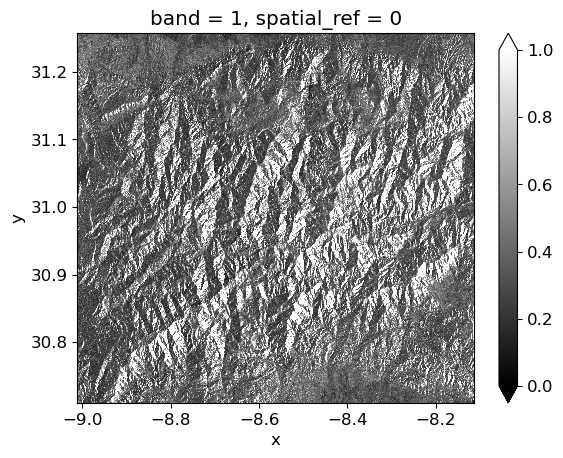

In [26]:
arr_amp = riox.open_rasterio(f"{dir_geo}/amp_prm_vv.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=0, vmax=1, cmap="gray")

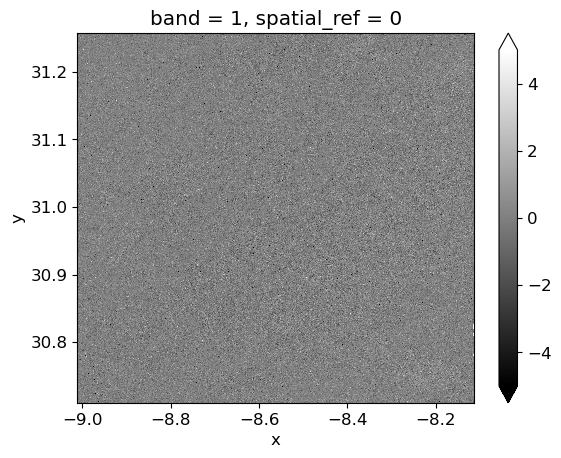

In [ ]:
arr_amp = riox.open_rasterio(f"{dir_geo}/change_vv.tif", masked=True)[0]
arr_amp.plot.imshow(vmin=-5, vmax=5, cmap="gray")

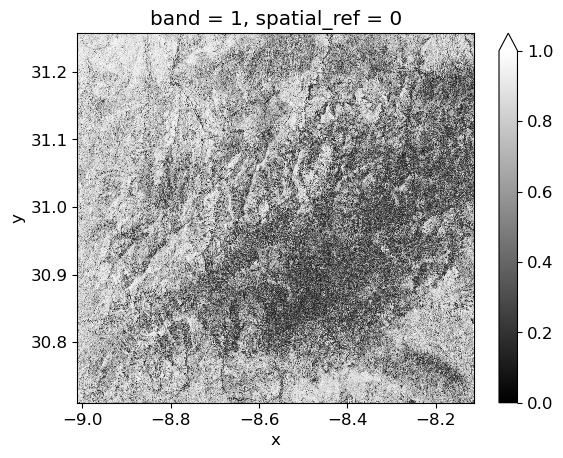

In [22]:
arr_coh = riox.open_rasterio(f"{dir_geo}/coh_vv.tif", masked=True)[0]
arr_coh.plot.imshow(vmin=0,vmax=1, cmap="gray")